In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/My Drive/tulhack/icml_face_data.csv')

In [ ]:
t = [int(x) for x in data[' pixels'][0].split(' ')]

In [ ]:
test_photo = np.array(t).reshape((48, 48))

In [ ]:
test_photo

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ...,
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]])

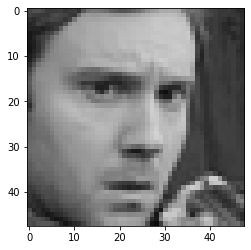

In [ ]:
plt.imshow(test_photo, cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
data[' pixels']

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name:  pixels, Length: 35887, dtype: object

In [ ]:
format_input = []
for i in tqdm.tqdm(data[' pixels']):
    temp = np.array([int(x) for x in i.split(' ')]).reshape((48,48))
    format_input.append(temp)

100%|██████████| 35887/35887 [00:20<00:00, 1726.36it/s]


In [ ]:
format_input = np.array(format_input)
format_input = np.append(format_input, format_input[:, :, ::-1], axis=0)

In [ ]:
np.save('photos.npy', format_input)

In [ ]:
format_input = np.array(np.load('photos.npy'))

In [ ]:
labels = list(data['emotion'].append(data['emotion']))

In [ ]:
class CNN_emotions(torch.nn.Module):
    def __init__(self):
        super(CNN_emotions, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.cnn5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.cnn6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.cnn7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.cnn1_bn = nn.BatchNorm2d(8)
        self.cnn2_bn = nn.BatchNorm2d(16)
        self.cnn3_bn = nn.BatchNorm2d(32)
        self.cnn4_bn = nn.BatchNorm2d(64)
        self.cnn5_bn = nn.BatchNorm2d(128)
        self.cnn6_bn = nn.BatchNorm2d(256)
        self.cnn7_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)
        self.dropout = nn.Dropout(0.3)
        self.fun = nn.Softmax()
    def forward(self, x):
        x = x.float().unsqueeze(1)
        x = self.pool1(self.cnn1_bn(self.cnn1(x)))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool1(self.cnn2_bn(self.dropout(self.cnn2(x))))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool1(self.cnn3_bn(self.cnn3(x)))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool1(self.cnn4_bn(self.dropout(self.cnn4(x))))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool2(self.cnn5_bn(self.cnn5(x)))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool2(self.cnn6_bn(self.dropout(self.cnn6(x))))
        x = self.relu(x)
#         print(x.shape)
        x = self.pool2(self.cnn7_bn(self.dropout(self.cnn7(x))))
        x = self.relu(x)
#         print(x.shape)

        x = x.view(x.size(0), -1)
#         print(x.shape)

        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return (x)

In [ ]:
def loss_function(pred, true):
    loss = nn.CrossEntropyLoss()
    return(loss(pred, true))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN_emotions().to(device)



In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=1e-3)
optimizer2 = torch.optim.Adam(model.parameters(), 
                       lr=1e-4)
optimizer3 = torch.optim.Adam(model.parameters(), 
                       lr=1e-5)

In [ ]:
format_input = torch.tensor(format_input)

In [ ]:
loss_function(model.forward((format_input[:5]).to(device)), torch.tensor(labels[:5]).to(device))

tensor(2.0556, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(format_input, torch.tensor(labels), test_size=0.1, random_state=42)

In [ ]:
num_epochs = 150
batch_size = 1000
n_batches_per_epoch = 5

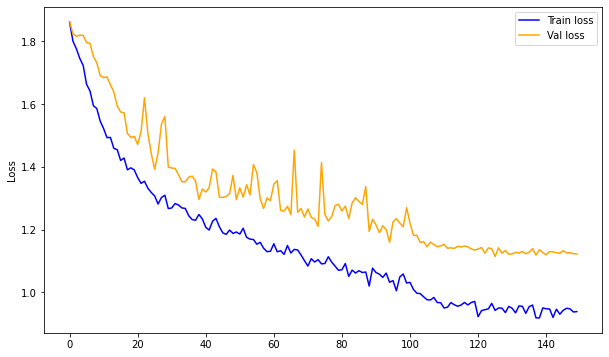

In [ ]:
train_losses = []
val_losses = []
for i in range(num_epochs):
    train_loss=0
    val_loss = 0
    model.train(True)
    batch_indexes = np.random.permutation(len(X_train))
    batch_indexes_2 = np.random.permutation(len(X_test))
    for j in range(0, n_batches_per_epoch*batch_size, batch_size):
        optimizer.zero_grad()
        indexes = batch_indexes[j:j+batch_size]
        x_batch = (X_train[indexes]).to(device)
        y_batch = (y_train[indexes]).to(device)
        pred = model.forward(x_batch)
        loss_value = loss_function(pred, y_batch)
        loss_value.backward()
        if i<=100:
          optimizer.step()
        elif i>100 and i<=120:
           optimizer2.step()
        else:
          optimizer3.step()
        train_loss += loss_value.item()
    train_loss /= n_batches_per_epoch
    train_losses.append(train_loss)
    model.train(False)
    for j in range(0, n_batches_per_epoch*batch_size, batch_size):
        indexes = batch_indexes_2[j:j+batch_size]
        x_batch = (X_test[indexes]).to(device)
        y_batch = (y_test[indexes]).to(device)
        pred = model.forward(x_batch)
        loss_value = loss_function(pred, y_batch)
        val_loss += loss_value.item()
        print(accuracy_score(pred.argmax(axis=-1).cpu().detach().numpy(), y_batch.cpu().detach().numpy()))
    val_loss /= n_batches_per_epoch
    val_losses.append(val_loss)
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/tulhack/res_model.pth')

In [ ]:
# model = torch.load('/content/drive/My Drive/tulhack/res_model.pth')
# model.eval()

In [ ]:
em = CNN_emotions()

In [ ]:
em.load_state_dict(torch.load('/content/drive/My Drive/tulhack/res_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
em.forward(X_test[:30]).argmax(axis=-1)

tensor([3, 2, 4, 6, 3, 4, 4, 4, 4, 3, 3, 0, 2, 4, 3, 0, 4, 3, 6, 2, 3, 6, 3, 4,
        0, 5, 0, 4, 3, 3])

In [ ]:
y_test[:30]

tensor([3, 2, 4, 6, 3, 4, 3, 0, 4, 6, 6, 4, 2, 4, 3, 0, 2, 3, 6, 2, 3, 5, 3, 3,
        0, 5, 6, 4, 2, 3])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(em.forward(X_test[:100]).argmax(axis=-1), y_test[:100])

0.72

In [ ]:
accuracy_score(em.forward(X_test[:1000]).argmax(axis=-1), y_test[:1000])